# radbin — Fluence-Scaled Poisson Binning
Implements a reset-aware, fluence-scaled binning pipeline to estimate radiation-normalized failure rates with exact Poisson (Garwood) CIs, plus CLI, plots, and tests.

### Area normalization
If run2 used 16 subsystems and run3 used 32, compare them at equal effective area by passing the run's area and your chosen reference:
```
--area-run 16 --area-ref 32    # scales rates by 32/16 = 2×
```

## API (import from `radbin`)
- `to_datetime_smart(series)` — robust parser
- `compute_scaled_time_clipped(…)` — adds `dt_eq`, `t_eq`, `scale_ratio`
- `extract_event_times(fails_df)` — one timestamp per increment of cumulative counter
- `detect_resets(…)`, `build_bins_reset_locked(…)`
- `build_bins_equal_fluence(…)`, `build_bins_equal_count(…)`
- `garwood_rate_ci(N, T, alpha)` — exact CI on λ
- `build_and_summarize(…)` — orchestrates everything and returns a DataFrame
- `poisson_trend_test(df_stats)` — GLM Poisson slope with offset log(T)

## Plots
- **Cumulative**: sanity-check for monotonicity and resets.
- **Fluence**: equal `Δt_eq` bins; if the device is in plateau, rates should look stationary.
- **Equal-count**: roughly constant precision because `σ_rel ≈ 1/√N`.




In [1]:
from radbin.core import (
    to_datetime_smart, compute_scaled_time_clipped, extract_event_times,
    build_and_summarize, inspect_scaled_time, plot_cumulative_fails,
    errorbar_rates, plot_scaling_ratio
)

In [2]:
import argparse, os
import numpy as np
import pandas as pd

from radbin.glm import poisson_trend_test
from radbin.synth import synth_beam, synth_fails_from_hazard
from radbin.plots import bar_rates
import matplotlib.pyplot as plt

def load_csv_or_none(path):
    if path is None:
        return None
    return pd.read_csv(path)

In [6]:

# PATHS
beam_csv = "../1_data/beam2.csv"
fails_csv = "../1_data/df2_valid.csv"
out_prefix = "out/run"

area_run = 32 # Efective area of this run (prop to number of sub systems)
area_ref = 16 # Reference area to normalize to 

# Garwood CI tail probability
alpha= 5/100

# event config
min_events = 5 # minimum events per bin
n_bins_flu = 30 # Number of "fluence scaled" bins
target_N = 100 # Target events per equal-count bin


# -- synth option --
synth = False

if synth: # Use synthetic data instead of CSVs
    beam = synth_beam()
    fails = synth_fails_from_hazard(beam, hazard_mode="bathtub", plateau_level=0.01, rate_scale=0.6, reset_every_s=1800)
else:
    beam = load_csv_or_none(beam_csv)
    fails = load_csv_or_none(fails_csv)
    if beam is None or fails is None:
        raise SystemExit("Both --beam and --fails must be provided unless --synth is set")


# Normalize columns
for df in (beam, fails):
    if "time" in df.columns:
        df["time"] = to_datetime_smart(df["time"])
#--

Limpieza de datos para beam_on

In [7]:
from functools import partial

# ---  Escalado por FLUENCIA para inspección ---
beq_phi = compute_scaled_time_clipped(beam, mode="fluence")
inspect_scaled_time(beq_phi, label="beam (fluence)")  # aquí scale_ratio ≡ phi_eff

# --- Filtrar eventos a beam_on==1 (evita N>0 con ΔΦ≈0) ---
beam_step = beam[["time","beam_on"]].sort_values("time").copy()
beam_step["beam_on"] = pd.to_numeric(beam_step["beam_on"], errors="coerce").fillna(0).astype(int)

fails_sorted = fails.sort_values("time").copy()
fails_on = pd.merge_asof(fails_sorted, beam_step, on="time", direction="backward")
fails_on = fails_on[fails_on["beam_on"] == 1].drop(columns=["beam_on"])

print("Eventos antes:", len(fails_sorted), " | después de filtrar beam_on:", len(fails_on))


# --- Umbral de exposición mínima por bin (adaptativo) ---
# Exposición total (ΔΦ total) y exposición "ideal" por bin
total_phi = beq_phi["dt_eq"].sum()
phi_per_bin_ideal = total_phi / max(1, n_bins_flu)

# Define un mínimo: p.ej. 20% de la exposición ideal por bin
T_min = 1/phi_per_bin_ideal
print(f"ΔΦ total={total_phi:.3f}  |  ΔΦ/bin ideal={phi_per_bin_ideal:.3f}  |  T_min={T_min:.3f}")

[inspect_scaled_time] beam (fluence): median=0.000189, p99=0.000355, max=0.000413
Eventos antes: 1030123  | después de filtrar beam_on: 628270
ΔΦ total=84.948  |  ΔΦ/bin ideal=2.832  |  T_min=0.353


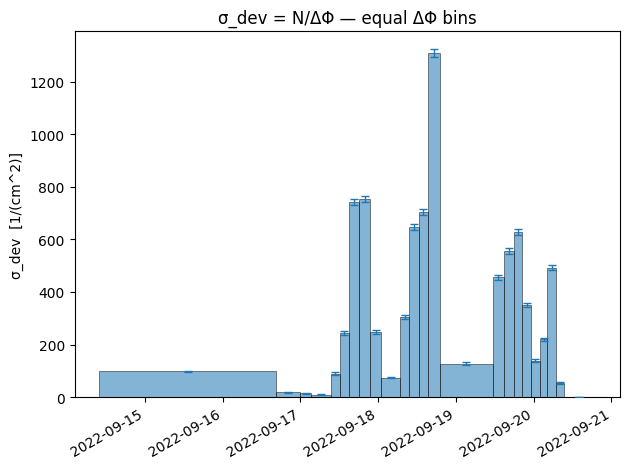

count    24.000000
mean      3.539000
std       1.912932
min       2.819749
25%       2.827946
50%       2.831923
75%       2.840352
max      11.325593
Name: T, dtype: float64
                         t_start                         t_end     N  \
20 2022-09-20 01:48:58.911934720 2022-09-20 04:14:57.492092160  1242   
10 2022-09-18 06:50:59.081225728 2022-09-18 09:31:39.027940096  1719   
2  2022-09-16 23:59:11.809666048 2022-09-17 03:17:30.258182144    83   
15 2022-09-19 11:19:33.028857344 2022-09-19 14:43:21.989831936  2576   
7  2022-09-17 18:09:53.276504576 2022-09-17 21:36:27.493708544  4256   

           T        rate  
20  2.819749  220.232376  
10  2.823250  304.436366  
2   2.826001   14.685064  
15  2.826729  455.650366  
7   2.827398  752.635566  
Classic GLM
GLM trend (FLU ): slope_per_hour=0.006385, p=2.071e-01, AIC=50141.9
---
[robust] RR por hora=1.00641 CI95%=(0.99647,1.01644); Wald p=0.207; LRT p=0; phi=2451.78 | TOST(rr±): p=0.241, eq@α=0.05: False
                 

In [ ]:
# --- Binning por FLUENCIA con merges por exposición y por N ---
res_flu = build_and_summarize(
    beam, fails_on,
    bin_mode="fluence", n_bins=n_bins_flu,
    T_source="beam",
    scaled_time_fn=lambda df, **kw: compute_scaled_time_clipped(df, mode="fluence", **kw),
    area_norm=(area_run, area_ref),
    min_events_per_bin=min_events,
    min_exposure_per_bin=T_min,   # ver abajo cómo elegirlo
)


# --- Plots con etiquetas correctas ---
ax = bar_rates(res_flu, title="σ_dev = N/ΔΦ — equal ΔΦ bins", y_label="σ_dev [1/(cm^2)]", logy=False)
plt.ylabel("\lambda " )  # ajusta a tus unidades reales de flujo
# plt.yscale("log")             
plt.show()





print(res_flu["T"].describe())
print(res_flu.nsmallest(5, "T")[["t_start","t_end","N","T","rate"]])

# --- GLM (sobre bins ya saneados) ---
print("Classic GLM")
tr_flu = poisson_trend_test(res_flu, x_col="t_mid")
print("GLM trend (FLU ): slope_per_hour=%.4g, p=%.3e, AIC=%.1f"
      % (tr_flu["slope_per_hour"], tr_flu["p_value"], tr_flu["AIC"]))
print("---")
from radbin.glm import poisson_trend_test_plus, format_trend_report
# --- GLM teniendo en cuenta sobredispersión y N grandes
# Suponiendo que ya tienes 'res_flu' con columnas N, T, t_mid (datetime)
out = poisson_trend_test_plus(
    res_flu,
    count="N", exposure="T", time_col="t_mid",
    alpha=0.05,
    se_method="robust",             # recomendado por defecto
    use_lrt=True,
    equivalence_rr=1.01,            # ±1% por hora = irrelevante
    standardize_time=True           # reporta también slope por SD(t)
)

print(format_trend_report(out, time_unit="hora", alpha=0.05))
# Si quieres ver un resumen corto del ajuste:
print(out["summary_head"])



### Sobre el modelo:
Sea en log-rate
$$
\hat\beta_1 = 0.0016 \quad (\text{log-rate por hora})
$$

Lo que importa no es el log, sino el **multiplicador de la tasa** por cada hora adicional:

$$
\text{Rate Ratio (RR)} = e^{\hat\beta_1} = e^{0.0016} \approx 1.0016
$$

Esto significa que, al avanzar una hora en el tiempo, la tasa esperada de fallos se multiplica por **1.0016**, es decir, aumenta un **0.16% por hora**.

Con el IC95%:

* Límite inferior: $e^{-0.004} \approx 0.996$ → posible **−0.4% por hora**
* Límite superior: $e^{0.007} \approx 1.007$ → posible **+0.7% por hora**


**El modelo general (General Linear Model)** es:

$$
\log \mathbb{E}[N_i] = \beta_0 + \beta_1 t_i + \log(T_i)
$$

* $N_i$: número de fallos en el bin $i$
* $T_i$: exposición (tiempo o fluencia en el bin)
* $t_i$: tiempo (horas desde el inicio)

**Hipótesis nula $H_0$:**

$$
\beta_1 = 0
$$

Esto equivale a que la tasa de fallos (ajustada por exposición) es **constante en el tiempo**.

**Hipótesis alternativa $H_1$:**

$$
\beta_1 \neq 0
$$

La tasa varía linealmente con el tiempo (en log-escala, o multiplicativamente en tasa).


#### Interpretación p-valor



En la salida

$$
p = 0.546
$$

Esto significa:

* Si en realidad la tasa de fallos **fuera constante** ($\beta_1=0$), la probabilidad de observar un efecto tan extremo o más que 0.0016 (en relación a su error estándar) sería de 54.6%.
* Como es muy grande, **no hay evidencia contra $H_0$**.
* En lenguaje práctico: el test no detecta ninguna tendencia clara; los datos son consistentes con una tasa estable.




In [6]:
# Comprobacions de sanidad

# Fluencia total y por bin
beq_phi = compute_scaled_time_clipped(beam, mode="fluence")
total_phi = beq_phi["dt_eq"].sum()
print("Total ΔΦ =", total_phi)

print("res_flu bins:", len(res_flu))
print("ΔΦ bin (p50, p10, p90) =", res_flu["T"].median(), res_flu["T"].quantile(0.1), res_flu["T"].quantile(0.9))

# Top bins problemáticos (exposición mínima)
print(res_flu.sort_values("T").head(5)[["t_start","t_end","N","T","rate","lo","hi"]])

# ¿Hay eventos en beam_off?
bon = (pd.to_numeric(beam["beam_on"], errors="coerce").fillna(0) != 0)
on_window = (beam.loc[bon, "time"].min(), beam.loc[bon, "time"].max())
n_off = ((fails["time"] < on_window[0]) | (fails["time"] > on_window[1])).sum()
print("Eventos fuera de beam_on:", int(n_off))


Total ΔΦ = 176.3156914984252
res_flu bins: 29
ΔΦ bin (p50, p10, p90) = 5.87967448392231 5.868266801336838 5.887552296234743
                         t_start                         t_end     N  \
4  2022-11-10 15:42:56.999099904 2022-11-10 19:57:22.415841536  3068   
6  2022-11-10 23:42:51.965796352 2022-11-11 03:22:24.131413248  4375   
16 2022-11-12 19:53:27.996399616 2022-11-13 00:47:52.993699328  3543   
23 2022-11-14 04:11:00.016201728 2022-11-14 08:43:17.585958400  3690   
10 2022-11-11 15:46:06.118811904 2022-11-11 19:58:49.425742592  3734   

           T        rate          lo          hi  
4   5.861595  523.406985  514.009673  532.975173  
6   5.862803  746.230127  735.010513  757.620333  
16  5.864085  604.186343  594.091995  614.451389  
23  5.869312  628.693759  618.401299  639.156736  
10  5.871107  635.995892  625.645413  646.516828  
Eventos fuera de beam_on: 215072


In [10]:
res_flu.to_csv(f"{out_prefix}_fluence.csv", index=False)

# Plots
plot_cumulative_fails(fails, title="Cumulative fails Run 3")
plt.savefig(f"{out_prefix}_cum.png", dpi=150)
plt.close()

# errorbar_rates(res_wall, title="Rates — reset-locked (wall time T)")
# plt.savefig(f"{out_prefix}_wall_rates.png", dpi=150)
# plt.close()

ax = bar_rates(res_flu, title="Rates — equal scaled time (fluence) Run 3", y_label=r"$\sigma [cm^{-2}]$")
plt.savefig(f"{out_prefix}_fluence_rates.png", dpi=150)
plt.close()


plot_scaling_ratio(beam, label=r"Scaling ratio $\frac{dt_{eq}}{dt}$")
plt.savefig(f"{out_prefix}_scaleratio.png", dpi=150)
plt.close()


## 0) Qué entregan los DataFrames de salida

Cada `res_*` devuelve columnas:

* `N`: eventos en el bin (incrementos del acumulado).
* `T`: tiempo de exposición del bin
  – en *wall* es tiempo real; en *fluence* o *eqN* es **tiempo escalado** $Δtₑq$.
* `rate = N/T`: estimador MLE de la tasa de Poisson.
* `lo, hi`: IC **Garwood** exacto para la tasa.
* `t_start, t_end, t_mid, width_s`.

---

## 1) Inspect scaling

```python
beq = compute_scaled_time_clipped(beam)
inspect_scaled_time(beq, label="beam")
```

### ¿Qué calcula?

* `compute_scaled_time_clipped` añade:

  * `dt_eq = dt · clip(φ_ref/φ_eff, 0, rmax)` con **floor** del flujo y **freeze** cuando `beam_on=0`.
  * `t_eq` (acumulado) y `scale_ratio = dt_eq/dt`.
* `inspect_scaled_time` resume la distribución de `scale_ratio` (mediana, p99, máx).

### ¿Qué esperar?

* **Mediana ≈ 1** si tu φ efectiva suele estar cerca de φ\_ref.
* **p99** moderado (p.ej. < 5–10) y **máx** ≪ `rmax` → sin *clipping* agresivo.
* Si **mediana < 1**: típicamente φ\_eff > φ\_ref (tiempo escalado “se comprime”).
* Si **mediana > 1**: φ\_eff < φ\_ref (tiempo escalado “se expande”).

### Red flags

* `p99` muy alto o `max` cercano a `rmax` → el floor o el cap están dominando y pueden distorsionar Δtₑq.

---

## 2) Vista **reset-locked** (tiempo real)

```python
res_wall = build_and_summarize(
  beam, fails, bin_mode="reset", T_source="wall",
  k_multiple=1, min_events_per_bin=min_events, area_norm=(area_run, area_ref)
)
```

### ¿Qué calcula?

* **Bordes de bins** pegados a **resets** (caídas/edges del acumulado y de `lfsrTMR`, clusterizados).
* `T` = **tiempo real** del bin, `N` = eventos en ese intervalo.
* `rate = N/T` con IC de Garwood.
* Si algún bin queda con `N < min_events`, se **fusiona** con el siguiente.

### ¿Qué esperar?

* Buena lectura “operativa” por ciclos de reset.
* Si el dispositivo está en **plateau**, las tasas deberían oscilar alrededor de un nivel \~constante (dentro de IC).
* Si hay **tendencia** (infant-mortality o desgaste), verás **pendiente** a través de bins.

### Checks rápidos

* La suma de `T` debe ser \~ la suma de `width_s` (consistencia de tiempo real).
* Ojo con bins muy largos con mucho tiempo **beam\_off**: pueden diluir la tasa.

---

## 3) Vista **equal-Δtₑq** (fluencia escalada)

```python
res_flu = build_and_summarize(
  beam, fails, bin_mode="fluence", n_bins=n_bins_flu,
  T_source="beam", min_events_per_bin=min_events, area_norm=(area_run, area_ref)
)
```

### ¿Qué calcula?

* Construye **n bins** con **igual tiempo escalado** `Δtₑq` (aprox), por lo que `T` es casi constante entre bins.
* `rate = N/T` refleja variación **intrínseca** del dispositivo (perfil del haz ya normalizado).

### ¿Qué esperar?

* En **plateau**: tasas casi **planas** (solo ruido de conteo, IC se solapan).
* En **bathtub** o **desgaste**: tasas con **U** (bathtub) o **pendiente** (desgaste).
* AIC/GLM suelen mejorar frente a la vista *wall* (modelo explica mejor).

### Checks

* Mira la columna `T`: debe ser **similar** entre bins (pequeña varianza).
* `rate` fuera de \[lo, hi] **no** debería ocurrir (si pasa, revisar inputs).

---

## 4) Vista **equal-count** (precisión constante)

```python
res_eqN = build_and_summarize(
  beam, fails, bin_mode="count", target_N=target_N,
  T_source="beam", min_events_per_bin=min_events, area_norm=(area_run, area_ref)
)
```

### ¿Qué calcula?

* Bins que contienen **≈ target\_N** eventos (después de merges), lo que hace que la **precisión relativa** sea \~constante:
  $\sigma_{\text{rel}}(\hat\lambda) \approx 1/\sqrt{N}$.

### ¿Qué esperar?

* **N** casi constante por bin; los **anchos de tiempo** se adaptan:
  – periodos de **alta tasa** → bins **cortos** en tiempo;
  – **baja tasa** → bins **largos**.
* Útil para comparar niveles de tasa con IC de magnitud similar a lo largo del eje.

### Checks

* `N` ≈ `target_N` (salvo el último bin o merges).
* `T` variable: es normal y deseable en esta vista.

---

## 5) Normalización por **área**

Aplica en las tres vistas vía `area_norm=(area_run, area_ref)`:

* Se escala `rate, lo, hi` por el factor $(A_{ref}/A_{run})$.
* Ej.: run3 con 16 subsistemas vs referencia 32 → factor **2×**.

---

## 6) Qué patrón valida cada vista

* **reset-locked (wall)**: “¿mi tasa cambia por ciclo/operación?” (incluye efectos de *duty cycle* del haz).
* **equal-Δtₑq**: “¿mi dispositivo muestra tendencia intrínseca una vez quitado el perfil de haz?” → ideal para decidir **plateau vs. desgaste**.
* **equal-count**: “quiero barras de error comparables” para una figura clara y chequeo visual de no-estacionariedad.

---

## 7) Señales de alerta generales

* Muchos bins con `N < min_events` (poca potencia) → subir `min_events` o rebinar.
* `scale_ratio` con cola extrema (max \~ rmax) → revisar `min_frac`, `rmax`, y `beam_on`.
* `rate` fuera de \[lo, hi] → error de contabilidad de eventos/tiempos.

Con esto deberías poder leer cada CSV/plot sabiendo exactamente **qué mide** y **qué forma esperas** si estás en plateau, en *infant mortality* o en desgaste.
